# Setup

In [1]:
# imports
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from scida import load
import numpy as np
import dask
import dask.array as da
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# logging.root.setLevel(logging.INFO)

# more sensible choice for chunk size here
dask.config.set({'array.chunk-size': '1024MiB'})

# get some SLURM nodes
cluster = SLURMCluster(queue='p.large', cores=72, memory="500 GB",
                       processes=36, # mostly want processes; threads do not release GIL for I/O etc
                       scheduler_options={"dashboard_address": ":8844"})
cluster.scale(jobs=4)  # ask for 4 jobs
client = Client(cluster)

Warning! Using default configuration. Please adjust/replace in '/u/byrohlc/.config/scida/config.yaml'.


# Load data
## Global particles

In [2]:
series = load("TNG-Cluster")
ds = series.get_dataset(redshift=0.0)
data_all = ds.data
coords_all = data_all["PartType1"]["Coordinates"].magnitude

## Simple projection

In [3]:
nbins = 1024
ranges = [[0.0, ds.boxsize[0]], [0.0, ds.boxsize[0]]]
bins = np.linspace(0.0, ds.boxsize[0], nbins)
hist = da.histogramdd(coords_all[:,:2], bins=[nbins, nbins], range=ranges)[0].compute()

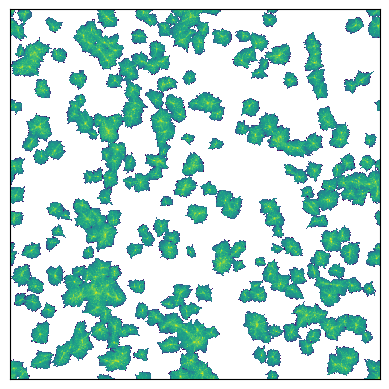

In [4]:
# white spaces as we only consider high-res particles ("PartType1"), not low-res ("PartType2")
plt.imshow(hist.T, origin="lower", norm=LogNorm(), interpolation="none")
plt.xticks([])
plt.yticks([])
plt.show()

## Local particles
Efficiently select a certain zoom-in target given TNG-Cluster layout

In [5]:
# let us select zoomID object 5, including its "fluff"
data_zoom = ds.return_data(zoomID=5, withfuzz=True)
coords_zoom = data_zoom["PartType1"]["Coordinates"]

In [6]:
idx = da.where(data_zoom["Group"]["GroupPrimaryZoomTarget"]==1)[0].compute()[0]
center = data_zoom["Group"]["GroupPos"][idx].compute().magnitude
radius = data_zoom["Group"]["Group_R_Crit200"][idx].compute().magnitude

In [7]:
nbins = 1024
bins = np.linspace(0.0, ds.boxsize[0], nbins)
ranges = [[center[0]-radius, center[0]+radius], [center[1]-radius, center[1]+radius]]
hist = da.histogramdd(coords_zoom[:,:2], bins=[nbins, nbins], range=ranges)[0].compute()

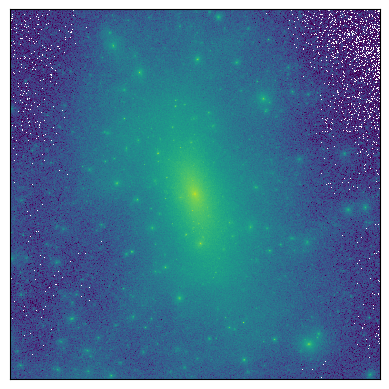

In [8]:
plt.imshow(hist.T, origin="lower", norm=LogNorm(), interpolation="none")
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
cluster.close()